# Multi-label classification

> PASCAL 2007 dataset
- order: 2
- callout-appearance: simple
- image: thumbnail.png
- toc-depth: 2
- date: 2023-03-10

Multi-label classification is a classification task where each sample can be assigned to multiple classes. This is different from multi-class classification where each sample can only be assigned to one class. Here I'll follow [FastAI's book, chapeter 6](https://github.com/fastai/fastbook).

First let's get the dataset:

In [32]:
#| hide
!pip install nbdev

In [33]:
#| hide
from blog import set_env
set_env()

In [34]:
from fastai.vision.all import *
from tips.plot import plot_pil_images
from nbdev.showdoc import *

In [35]:
path = untar_data(URLs.PASCAL_2007)

Let's take a look at the data, this dataset has a csv file with the info:

In [36]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


so we have `filename`, `label` (which is in fact multi-label) and `is_valid` (True if we want it in validation set, probably useful for bencharmarking since this info is not necceseary).

The dataset also has segmentation masks (for 422 out of 5011 images). No need for that now but good to know.

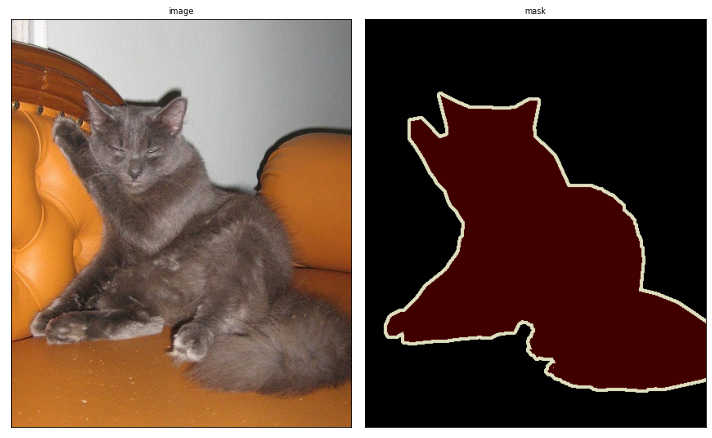

In [37]:
#| hide
idx = '002470'
im = PILImage.create(path/'train'/ (idx + '.jpg'))
mask = PILImage.create(path/'segmentation'/ (idx + '.png'))
_ = plot_pil_images([im, mask], labels=['image', 'mask'])

# `DataBlock` preparation

`DataBlock` is fastai type that is used to create fastais `Datasets` and `DataLoaders` (which themselves are wrappers for PyTorch `Dataset` and `DataLoader`). Let's get to know it:

In [38]:
data_block = DataBlock()

One can create datasets from pandas dataframe:

In [39]:
datasets = data_block.datasets(df)

In [40]:
type(datasets)


fastai.data.core.Datasets

Datasets have train and valid parameters:

In [41]:
datasets.train[0]

(fname           005547.jpg
 labels      cow car person
 is_valid             False
 Name: 2784, dtype: object,
 fname           005547.jpg
 labels      cow car person
 is_valid             False
 Name: 2784, dtype: object)

but a text format is not useful for training. We can provide a `get_x` and `get_y` functions to `DataBlock` to get the data and labels:

In [42]:
def get_x(r):
    return path / 'train' / r['fname']
def get_y(r):
    return r['labels'].split()
datablock = DataBlock(blocks=[ImageBlock, MultiCategoryBlock],
                       get_x=get_x, get_y=get_y)
datasets = datablock.datasets(df)

In [43]:
datasets.train[0]

(PILImage mode=RGB size=500x374,
 TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

This looks better, since now we have image and a MultiCategory label. It is one hot encoded since we can have more then 1. or 0 for that matter. Let's also use the splitter that will use the `is_valid` column:

In [44]:
def splitter(df):
    train = L(df.index[~df['is_valid']].tolist())
    valid = L(df.index[df['is_valid']].tolist())
    return train, valid

In [45]:
def get_x(r):
    return path / 'train' / r['fname']
def get_y(r):
    return r['labels'].split()
data_block = DataBlock(blocks=[ImageBlock, MultiCategoryBlock],
                       splitter=splitter,
                       get_x=get_x, get_y=get_y)
datasets = data_block.datasets(df)
datasets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

We used `splitter` as a method, previously we used `RandomSplitter()`and dozen more (see doc below): 

In [46]:
doc(RandomSplitter)

We can get vocabulary of all classes (there are 20):

In [47]:
print(datasets.vocab)
print(len(datasets.vocab))

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
20


For example, the 0th training sample looks like this:

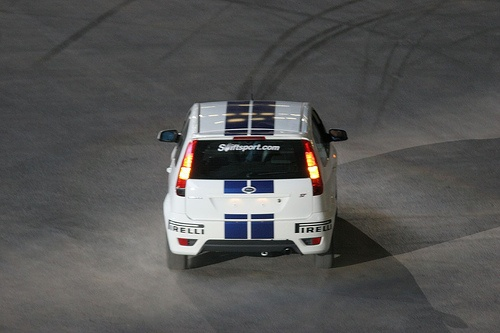

In [48]:
datasets.train[0][0]

In [49]:
idxs = datasets.train[0][1] == 1
print(idxs)
datasets.vocab[idxs]

TensorMultiCategory([False, False, False, False, False, False,  True, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False])


(#1) ['car']

so far so good. We can also use `torch.where`:

In [50]:
idxs = torch.where(datasets.train[0][1] == 1.0)[0]
print(idxs)
datasets.vocab[idxs]

TensorMultiCategory([6])


(#1) ['car']

We need to resize all the images to the same size, `PyTorch` can't store tensors otherwise, the min_scale 

In [51]:
datablock = DataBlock(blocks=[ImageBlock, MultiCategoryBlock],
                       get_x=get_x, get_y=get_y,
                       splitter=splitter,
                       item_tfms=RandomResizedCrop(128, min_scale=0.35))
datasets = datablock.datasets(df)

finally, let's create fastai `DataLoaders` as well (won't shuffle just yet):

In [52]:
dls = datablock.dataloaders(df, shuffle=False)

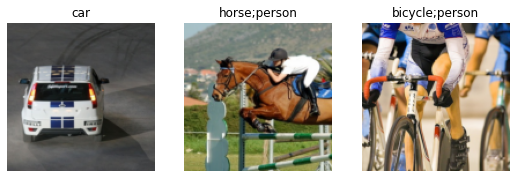

In [53]:
dls.show_batch(nrows=1, ncols=3)  # with min_scale = 0.35

`min_scale` controls the zoom, too low number (like 0.1) zooms and threatens to crop too much. Let's stick with 0.35.


# Training

First we define the model with dataloaders and model (optimizer and loss will be assigned automatically for now):

In [71]:
learn = vision_learner(dls, resnet50)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The warnings are becuase `vision_learner` still uses 0.13 version of torchvision. Not a big deal for now.

In [75]:
!pip show torchvision

Name: torchvision
Version: 0.13.0+cu116
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.9/dist-packages
Requires: numpy, pillow, requests, torch, typing-extensions
Required-by: fastai, sentence-transformers


I have to send the model to the device not sure why is this not automatic as with dataloaders:

In [55]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
learn.model = learn.model.to(device)

Let's first see what we get as an output after predicitons:

In [56]:
x,y = dls.train.one_batch()
activations = learn.model(x)
activations.shape

torch.Size([64, 20])

This makes sense, each item in a batch will predict a one-hot list of 20 classes. So waht loss type should we use? The answer is BinaryCrossEntropy, and that's the one `fastai` assigns automatically: 

In [57]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

`BCEWithLogitsLoss` is used since there is last layer in resnet18 is not sigmoid but linear layer with 20 outputs:

In [58]:
learn.model[-1][-1]

Linear(in_features=512, out_features=20, bias=False)

Let's also add a metric, `accuracy_multi` is the one we need and we should pass sigmoid=True since we want to convert logits to probabilities and let's have lower threshold:

In [59]:
accuracy_multi??

Signature: accuracy_multi(inp, targ, thresh=0.5, sigmoid=True)
Source:   
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
File:      /usr/local/lib/python3.9/dist-packages/fastai/metrics.py
Type:      function


In [76]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=3)

VSCode doesn't show the progress bar sometimes unfortunately.

Let's get the predictions:

In [84]:
preds, targets = learn.get_preds()

In [85]:
preds.shape


torch.Size([2510, 20])

In [86]:
targets.shape

torch.Size([2510, 20])

we can now plot accuracy for differnt thresholds (we use sigmoid=False since we already got probabilities via `get_preds`):

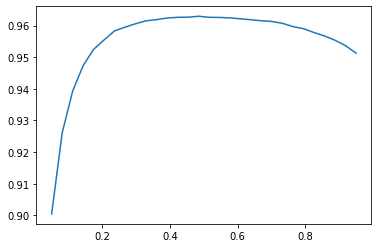

In [90]:
xs = torch.linspace(0.05, 0.95, 30)
accs = [accuracy_multi(preds, targets, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

So the max accuracy is:

In [114]:
max_idx, max_val = max(enumerate([float(x) for x in accs]), key=lambda x: x[1])
xs[max_idx], max_val

(tensor(0.4845), 0.962928295135498)

for threshold=0.48.

And this is it for multi-label classification.